In [6]:
# POde pular essa etapa se os pacotes já estão instalados
!pip install numpy
!pip install scikit-learn
!pip install scikit-image
!pip install librosa
!pip install tqdm
!pip install matplotlib
!pip install tensorflow

In [45]:
#ref: https://www.kaggle.com/code/msripooja/steps-to-convert-audio-clip-to-spectrogram
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import librosa
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.losses import CategoricalCrossentropy
from keras.models import Sequential, load_model
from keras.layers import GRU, LSTM, Conv2D, MaxPooling2D, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation, TimeDistributed
from PIL import Image
from keras.optimizers import Adam

#to play audio
import IPython.display as ipd


In [46]:
tipo_espectrograma = "mfcc"

# Nesse caso você precisa ter no seu diretório uma pasta com o mesmo nome da variável base_dir
base_dir = "clean_audioset"
# E dentro da pasta audioset, você precisa de 3 pastas: carros, motocicletas e motosserras contendo os áudios
audio_carro_path = base_dir + "/carros/"
audio_moto_path = base_dir + "/motocicletas/"  # caminho onde estão os arquivos de audio
audio_serra_path = base_dir + "/motosserras/"

spec_base_path = base_dir + f"/{tipo_espectrograma}"
spec_carro_path = os.path.join(spec_base_path, "carros")
spec_moto_path = os.path.join(spec_base_path, "motocicletas")
spec_serra_path = os.path.join(spec_base_path, "motosserras")
 
os.makedirs(spec_base_path, exist_ok=True)
os.makedirs(spec_carro_path, exist_ok=True)
os.makedirs(spec_moto_path, exist_ok=True)
os.makedirs(spec_serra_path, exist_ok=True)

FILE_FORMAT = "png"
TAM_IMAGEM = 40

In [47]:
audio_carro_clips = sorted(os.listdir(audio_carro_path))[:50]
print(f"Número de arquivos .wav na pasta {audio_carro_path}= ",len(audio_carro_clips))

audio_moto_clips = sorted(os.listdir(audio_moto_path))[:50]
print(f"Número de arquivos .wav na pasta {audio_moto_path}= ",len(audio_moto_clips))

audio_serra_clips = sorted(os.listdir(audio_serra_path))[:100]
print(f"Número de arquivos .wav na pasta {audio_serra_path}= ",len(audio_serra_clips))

Número de arquivos .wav na pasta clean_audioset/carros/=  50
Número de arquivos .wav na pasta clean_audioset/motocicletas/=  50
Número de arquivos .wav na pasta clean_audioset/motosserras/=  78


In [48]:
#aqui está selecionando o primeiro arquivo da lista, pode ser feito um for para pegar todos de uma vez
#verificar esse sample rate
x_carro, sr_carro = librosa.load(audio_carro_path+audio_carro_clips[0]) 
x_moto, sr_moto = librosa.load(audio_moto_path+audio_moto_clips[4]) 
x_serra, sr_serra = librosa.load(audio_serra_path+audio_serra_clips[6]) 

print(type(x_carro), type(sr_carro))
print(x_carro.shape, sr_carro)

print(type(x_moto), type(sr_moto))
print(x_moto.shape, sr_moto)

print(type(x_serra), type(sr_serra))
print(x_serra.shape, sr_serra)

<class 'numpy.ndarray'> <class 'int'>
(220676,) 22050
<class 'numpy.ndarray'> <class 'int'>
(114308,) 22050
<class 'numpy.ndarray'> <class 'int'>
(1323000,) 22050


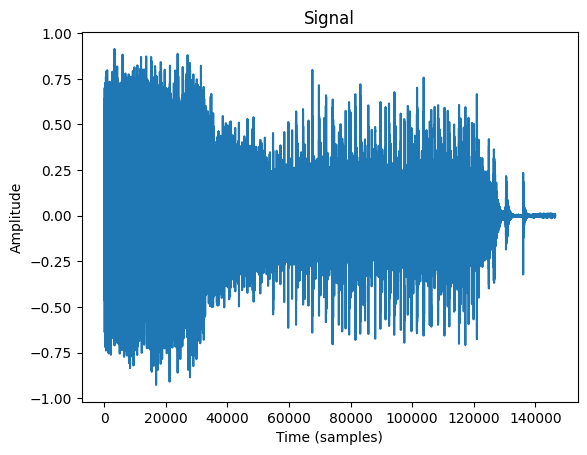

In [49]:
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(os.path.join(audio_serra_path, audio_serra_clips[20]))
plt.plot(y);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

[]
(40, 287)


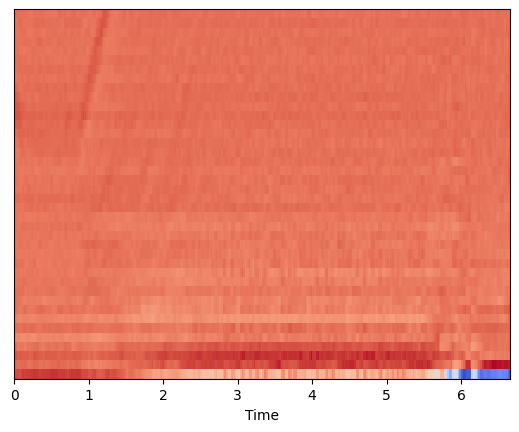

In [53]:
hop_length = 512 # in num. of samples
n_fft = 256 # window in num. of samples
n_mfcc=40

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                   fmax=8000)
spectrum = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
size_padding = TAM_IMAGEM - n_mfcc
padding = np.zeros((size_padding, spectrum.shape[1]))
    
spectrum = np.vstack((spectrum, padding))
# calculate abs values on complex numbers to get magnitude
# spectrum = np.abs(stft)
# spectrum = np.log(spectrum + 0.00000001)
librosa.display.specshow(spectrum, sr=sr, x_axis="time")

print(spectrum.shape)

# Salvar valores de espectrograma
 - Pule esse passo se os arquivos já estiverem na pasta

In [55]:
##converter o audio para espectrograma:
## é nesse amplitude_to_dB que ele está convertendo para pressão sonora. Podemos explorar outras ponderações aqui. Se não tiver implementado, podemos implementar.
def gerar_espectrograma(y, sample_rate):

    n_mfcc = 40
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                   fmax=8000)
    spectrum = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    size_padding = TAM_IMAGEM - n_mfcc
    padding = np.zeros((size_padding, spectrum.shape[1]))
        
    spectrum = np.vstack((spectrum, padding))

    return spectrum 


def cortar_espectrograma(spectrogram, largura_janela=TAM_IMAGEM, altura_janela=TAM_IMAGEM):
    altura_spec = spectrogram.shape[0]+1
    largura_spec = spectrogram.shape[1]
    spectrogram_slices = []

    if altura_janela > altura_spec:
        altura_janela = altura_spec-1

    for h in range(altura_janela, altura_spec, altura_janela):
        for w in range(largura_janela, largura_spec, largura_janela):
            slice = spectrogram[h-altura_janela : h,   # largura
                                w-largura_janela : w,  # altura
                                np.newaxis]
            spectrogram_slices.append(slice)
            
    return spectrogram_slices    
    
# end def

In [56]:

# Salvar espectrogramas na pasta específica (carros, serras etc)
def salvar_espectrogtramas (audio_clips, audio_path, spectrogram_path, audios_por_arquivo=50):
    numero_audios = len(audio_clips)
    num_arquivo = 1

    spectrogram_values = []
    
    for i, audio_name in enumerate(audio_clips):
        y, sr = librosa.load( os.path.join(audio_path, audio_name) )
        audio_name = audio_name.replace(".mp3", "").replace(".wav", "").replace(".m4a", "")

        fullpath = os.path.join(spectrogram_path, audio_name)
        try:
            mfcc_spec = gerar_espectrograma(y, sr)
            mfcc_spec = 255 * (mfcc_spec - mfcc_spec.min()) / (mfcc_spec.max() - mfcc_spec.min())
            mfcc_spec = np.flip(mfcc_spec, axis=0) # put low frequencies at the bottom in image
            mfcc_spec_slices = cortar_espectrograma(mfcc_spec)
        
            # Salva o arquivo e começa o próximo
            for j in range(len(mfcc_spec_slices)):

                full_filename = fullpath + f"_{j+1}.{FILE_FORMAT}"
                spec_save = mfcc_spec_slices[j][:, :, 0]

                if FILE_FORMAT == "csv":
                    np.savetxt(full_filename, spec_save, delimiter=",")
                else:
                    im = Image.fromarray(spec_save).convert("L")
                    im.save(full_filename)

            print("Arquivo %s salvo com sucesso." % full_filename)
                
        except Exception as e:
            print( "Erro ao salvar %s: %s." % (fullpath, e) )


salvar_espectrogtramas(audio_carro_clips, audio_carro_path, spec_carro_path)

salvar_espectrogtramas(audio_moto_clips, audio_moto_path, spec_moto_path)

salvar_espectrogtramas(audio_serra_clips, audio_serra_path, spec_serra_path)


Arquivo clean_audioset/mfcc/carros/(HD) - Forza 4 - Top Gear - Car Test - 1990 Lotus Carlton-0GZbu00-aMY_10.png salvo com sucesso.
Arquivo clean_audioset/mfcc/carros/1968 Chevy Camaro - V8 327 - MUSCLECAR SOUND - restauriert-1ddvRm8MURI_10.png salvo com sucesso.
Arquivo clean_audioset/mfcc/carros/1995 Toyota Supra FOR SALE-2-1wY_Ndtgw_10.png salvo com sucesso.
Arquivo clean_audioset/mfcc/carros/2013 Porsche 911 Carrera Start Up and Review 3.4 L Horizontally Opposed⧸6 Cylinder-9BzZvj5W09s_10.png salvo com sucesso.
Arquivo clean_audioset/mfcc/carros/95 Mustang drag car start up-1sjKon7lrLY_9.png salvo com sucesso.
Arquivo clean_audioset/mfcc/carros/99 Trans Am WS6 - Donuts, Take-Offs, 110MPH!-G4Rp68qV_aw_10.png salvo com sucesso.
Arquivo clean_audioset/mfcc/carros/A guy trying to start car after flood-0TGPaUN2V5Q_9.png salvo com sucesso.
Arquivo clean_audioset/mfcc/carros/AX kit car-1-Vhr9Ut4Tg_10.png salvo com sucesso.
Arquivo clean_audioset/mfcc/carros/Atlanta GA： 1999 Jeep Grand Chero

# Treinamento e teste de rede neural

In [57]:
# Carregar espectrogramas com uma CNN e classificar entre "motosserras e não motosserras"

espectrogramas_carro = sorted(os.listdir(spec_carro_path))
espectrogramas_moto = sorted(os.listdir(spec_moto_path))
espectrogramas_serra = sorted(os.listdir(spec_serra_path))

spectrogram_list = []
labels = []

def carregar_espectrograma(full_filename):
    if FILE_FORMAT == "png":
        return np.asarray(Image.open(full_filename))
    else:
        return np.loadtxt(full_filename, delimiter=",")


def adicionar_rotulos_spec(espectrogramas, spec_path, label):
    for filename in espectrogramas:
        full_filename = os.path.join(spec_path, filename)  

        spectrogram = carregar_espectrograma(full_filename)
        spectrogram_list.append(spectrogram)
        # 0 corresponde aos carros e motos
        labels.append(label)


adicionar_rotulos_spec(espectrogramas_carro, spec_carro_path, 0)
adicionar_rotulos_spec(espectrogramas_moto, spec_moto_path, 0)
adicionar_rotulos_spec(espectrogramas_serra, spec_serra_path, 1)

spectrogram_np = np.array(spectrogram_list) / 255

spectrogram_np = spectrogram_np.reshape(
    (spectrogram_np.shape[0], spectrogram_np.shape[1], spectrogram_np.shape[2], 1)
)

labels_np = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    spectrogram_np, labels_np, test_size=0.2  # , random_state=42
)

print("Amostras treinamento:", len(X_train))
print("Amostras teste:", len(X_test))

Amostras treinamento: 1713
Amostras teste: 429


In [59]:
model = Sequential()

model.add(Conv2D(16, 3, activation='relu', use_bias=True, bias_initializer='zeros', input_shape=X_train[0].shape))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation='relu', use_bias=True, bias_initializer='zeros'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu', use_bias=True, bias_initializer='zeros'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # Binary classification
model.compile(loss='binary_crossentropy',
              optimizer = 'RMSProp',
              metrics=['accuracy'])
# Print model summaryImage.open
model.summary()
model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=16)

model.save(f"checkpoints/{tipo_espectrograma}.keras")

/home/gustavo/.venv/green_bug/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 38, 38, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 19, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 17, 17, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,433 (509.50 KB)

 Trainable params: 130,433 (509.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5489 - loss: 0.6885 - val_accuracy: 0.5423 - val_loss: 0.6731
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5885 - loss: 0.6713 - val_accuracy: 0.6210 - val_loss: 0.6337
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6915 - loss: 0.6067 - val_accuracy: 0.4694 - val_loss: 0.7839
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6742 - loss: 0.6083 - val_accuracy: 0.7609 - val_loss: 0.5488
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7126 - loss: 0.5758 - val_accuracy: 0.7143 - val_loss: 0.5661
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7466 - loss: 0.5332 - val_accuracy: 0.7434 - val_loss: 0.5209
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7568 - loss: 0.5125 - val_accuracy: 0.7668 - val_loss: 0.5118
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7461 - loss: 0.5383 - val_accuracy: 0.

In [31]:
model = load_model(f"checkpoints/{tipo_espectrograma}.keras")
y_pred = model.predict(X_test)[:, 0]
y_pred = np.round(y_pred)
acc = len(np.where(y_pred == y_test)[0]) / len(y_test)
print("Acurácia:", acc)

13/13 [==============================] - 1s 29ms/step
Acurácia: 0.5968992248062015
